<hr style="border:2px solid #0176DE"> </hr>
<center><h1 style="color:#173F8A;"> Escuela de Verano en Metodos Iterativos</h1></center> 
<center><h1 style="color:#173F8A;"> EMI 2024 - CMM Chile</h1></center>
<hr style="border:2px solid #0176DE"> </hr>
<h3 style="color:#173F8A;text-align:right;"> Profesores: &nbsp;Nicolás Barnafi<br>Manuel A. Sanchez<br></h3>

<h3 style="color:#03122E;text-align:right;"> 
    Centro de Modelamiento Matematico <br> 
    Instituto de Ingenieria Matematica y Computacional - IMC UC<br>  
</h3>

<hr style="border:2px solid #03122E"> </hr>
<center><h1 style="color:#173F8A;"> Modulo 1: Introducción</h1></center> 
<hr style="border:2px solid #03122E"> </hr>

<!-- Palette colors UC:
Primaria: 
celeste:#0176DE, azul #173F8A, azul oscuro: #03122E, amarillo: #FEC60D, amarillo oscuro: #E3AE00 
Secundaria
gris oscuro: #707070
-->

- The motivation

  3D simulations, HPC

- The actual motivation

  Upscale simulations, black-box never works

# The only requirement: Weak formulations

$$ -\Delta u = f \quad \Leftrightarrow \quad \int \nabla u \cdot \nabla v\,dx = \int f v\,dx \quad \forall v \in V_0$$

In [15]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *
import scipy.sparse as sp
from scipy.sparse.linalg import splu
from time import perf_counter
import matplotlib.pylab as plt

# Define geometry
#shape = Rectangle(2,0.41).Circle(0.2,0.2,0.05).Reverse().Face()
shape = Rectangle(2,0.41).Face()
shape.edges.name="wall"
shape.edges.Min(X).name="inlet"
shape.edges.Max(X).name="outlet"
geo = OCCGeometry(shape, dim=2)
Draw (shape);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': 3…

In [16]:
# Approximate geometry with a mesh
mesh = Mesh(geo.GenerateMesh(maxh=0.1))
#mesh.Curve(1)
Draw (mesh);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

In [17]:
# Functional space, trial and test functions
V = H1(mesh, order=2, dirichlet="wall|inlet|cyl")
u, v = V.TnT()

# Problem definition
form = InnerProduct(Grad(u), Grad(v))*dx
a = BilinearForm(form).Assemble()
f = LinearForm(v*dx).Assemble()
gf = GridFunction(V) # Solution vector

# Boundary condition
uin = CF(1.5*4*y*(0.41-y)/(0.41*0.41))
gf.Set(uin, definedon=mesh.Boundaries("inlet"))

# Solution with sparse LU factorization
res = f.vec -a.mat * gf.vec
inv = a.mat.Inverse(freedofs=V.FreeDofs(), inverse="umfpack")
gf.vec.data += inv * res
Draw(gf)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [18]:
# Now we compute the nonzeros in the LU factorization
rows,cols,vals = a.mat.COO()
nnzA = len(vals)
A = sp.csr_matrix((vals,(rows,cols))) # NGSolve mat to scipy.sparse
LU = splu(A)
nnzs = LU.L.nnz + LU.U.nnz
print("Number of non-zeros of A:", nnzA)
print("Number of non-zeros of L+U:", nnzs)
print("Ratio of non-zeros:", len(vals)/nnzs)

Number of non-zeros of A: 4103
Number of non-zeros of L+U: 13404
Ratio of non-zeros: 0.3061026559236049


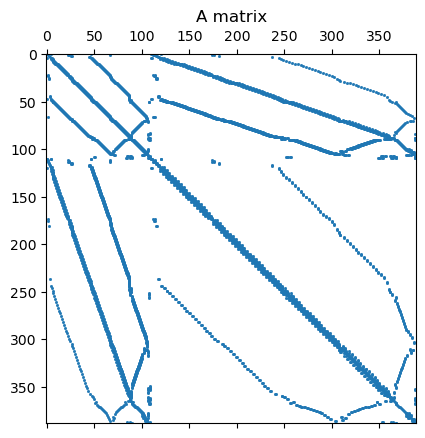

In [19]:
# Spy arrays
plt.spy(A, markersize=1.0)
plt.title("A matrix")
plt.show()

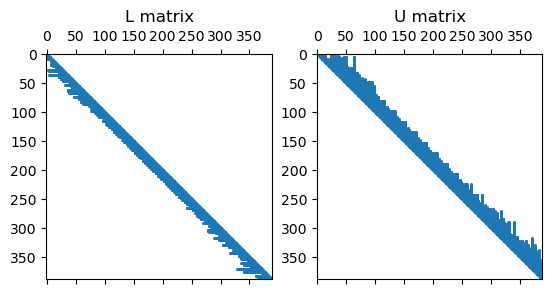

In [20]:
plt.subplot(1,2,1)
plt.spy(LU.L, markersize=1)
plt.title("L matrix")
plt.subplot(1,2,2)
plt.spy(LU.U, markersize=1)
plt.title("U matrix")
plt.show()

In [21]:
def convertToMb(nval):
    # 8 bytes per val 
    return nval * 8 * 1e-6
    
def computeNonzeros(maxh):
    mesh = Mesh(geo.GenerateMesh(maxh=maxh))
    mesh.Curve(3)
    V = VectorH1(mesh, order=2, dirichlet="wall|inlet|cyl")
    Q = H1(mesh, order=1)
    X = V*Q
    (u,p),(v,q) = X.TnT()
    
    stokes = InnerProduct(Grad(u), Grad(v))*dx + div(u)*q*dx + div(v)*p*dx
    a = BilinearForm(stokes)
    a.Assemble()
    rows,cols,vals = a.mat.COO()
    nnzA = len(vals)
    
    import scipy.sparse as sp
    A = sp.csr_matrix((vals,(rows,cols)))
    from scipy.sparse.linalg import splu # Sparse LU
    
    LU= splu(A)
    nnzs = LU.L.nnz + LU.U.nnz
    print("Number of non-zeros of A:", nnzA, "(in {:1.3f} Mb)".format(convertToMb(nnzA)))
    print("Number of non-zeros of L+U:", nnzs, "(in {:1.3f} Mb)".format(convertToMb(nnzs)))
    print("Ratio A.nnz / LU.nnz:", nnzA/nnzs)
    return nnzA, nnzs

In [22]:
for h in [0.1, 0.05, 0.01, 0.005]:
    print(f"========= Using h={h:1.3f}")
    nnza, nnzlu = computeNonzeros(h)

========= Using h=0.100
Number of non-zeros of A: 24024 (in 0.192 Mb)
Number of non-zeros of L+U: 74931 (in 0.599 Mb)
Ratio A.nnz / LU.nnz: 0.320614965768507
========= Using h=0.050
Number of non-zeros of A: 103041 (in 0.824 Mb)
Number of non-zeros of L+U: 642311 (in 5.138 Mb)
Ratio A.nnz / LU.nnz: 0.16042228764570435
========= Using h=0.010
Number of non-zeros of A: 2532409 (in 20.259 Mb)
Number of non-zeros of L+U: 57382418 (in 459.059 Mb)
Ratio A.nnz / LU.nnz: 0.04413214166053442
========= Using h=0.005
Number of non-zeros of A: 10091084 (in 80.729 Mb)
Number of non-zeros of L+U: 315893683 (in 2527.149 Mb)
Ratio A.nnz / LU.nnz: 0.0319445577517294


In [106]:
from time import perf_counter
def solveDirect(maxh, p):
    # Functional space, trial and test functions
    mesh = Mesh(geo.GenerateMesh(maxh=maxh))
    V = H1(mesh, order=p, dirichlet="wall|inlet|cyl")
    u, v = V.TnT()
    
    # Problem definition
    form = InnerProduct(Grad(u), Grad(v))*dx
    a = BilinearForm(form).Assemble()
    f = LinearForm(v*dx).Assemble()
    gf = GridFunction(V)
    
    # Boundary condition
    uin = CF(1.5*4*y*(0.41-y)/(0.41*0.41))
    gf.Set(uin, definedon=mesh.Boundaries("inlet"))

    # Solve
    t0 = perf_counter()
    inv = a.mat.Inverse(inverse="umfpack")
    gf.vec.data += inv * gf.vec
    tf = perf_counter() - t0
    return V.ndofglobal, tf

def solveIterative(maxh, p):
    # Functional space, trial and test functions
    mesh = Mesh(geo.GenerateMesh(maxh=maxh))
    V = H1(mesh, order=p, dirichlet="wall|inlet|cyl")
    u, v = V.TnT()
    
    # Problem definition
    form = InnerProduct(Grad(u), Grad(v))*dx
    a = BilinearForm(form)
    f = LinearForm(v*dx)
    gf = GridFunction(V)
    
    # Boundary condition
    uin = CF(1.5*4*y*(0.41-y)/(0.41*0.41))
    gf.Set(uin, definedon=mesh.Boundaries("inlet"))
    
    # Solution with AMG
    pre = Preconditioner(a, "bddc", coarsetype="h1amg")
    a.Assemble()
    f.Assemble()
    t0 = perf_counter()
    inv = solvers.CG(a.mat, f.vec, pre=pre, sol=gf.vec, tol=1e-10, printrates='\r', maxsteps=500)
    tf = perf_counter() - t0
    return V.ndofglobal, tf


In [55]:
maxh = 0.01
tfds = []
tfis = []
maxhs = [0.1/2**i for i in range(6)]
dofs = []
for maxh in maxhs:
    print(f"========= Solving for h={maxh:1.2e}")
    dofd, tfd = solveDirect(maxh, 2)
    _, tfi = solveIterative(maxh, 2)
    tfis.append(tfi)
    tfds.append(tfd)
    dofs.append(dofd)
    print(f"Dofs: {dofd:6.0f}, Direct: {tfd:1.3e}s, Iterative: {tfi:1.3e}s")

========= Solving for h=1.00e-01
CG converged in 16 iterations to residual 2.35612470606949e-12
Dofs:    389, Direct: 6.795e-04s, Iterative: 1.225e-03s
========= Solving for h=5.00e-02
CG converged in 16 iterations to residual 5.582054244976594e-12
Dofs:   1601, Direct: 2.753e-03s, Iterative: 1.737e-03s
========= Solving for h=2.50e-02


CG converged in 18 iterations to residual 3.645630942768382e-12
Dofs:   6269, Direct: 1.201e-02s, Iterative: 5.100e-03s
========= Solving for h=1.25e-02


CG converged in 22 iterations to residual 2.3801462934688545e-12
Dofs:  24747, Direct: 5.335e-02s, Iterative: 2.113e-02s
========= Solving for h=6.25e-03


CG converged in 26 iterations to residual 3.5197229730126614e-12
Dofs:  97421, Direct: 3.344e-01s, Iterative: 1.147e-01s
========= Solving for h=3.13e-03


CG converged in 31 iterations to residual 4.0503272801982096e-12
Dofs: 389395, Direct: 1.957e+00s, Iterative: 8.453e-01s
========= Solving for h=1.56e-03


CG converged in 39 iterations to residual 3.337343880333909e-12
Dofs: 1554605, Direct: 9.994e+00s, Iterative: 5.760e+00s


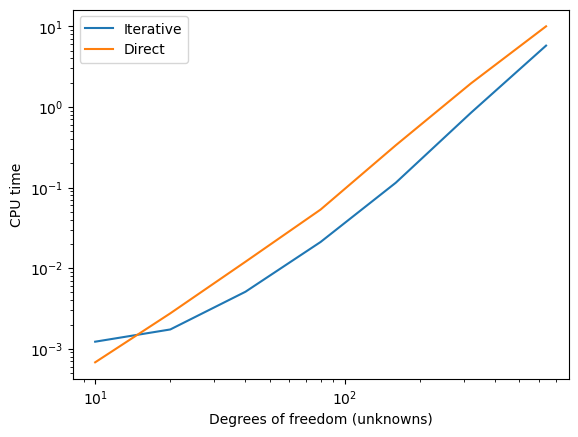

In [56]:
plt.loglog(dofs, tfis, label="Iterative")
plt.loglog(dofs, tfds, label="Direct")
plt.xlabel("Degrees of freedom (unknowns)")
plt.ylabel("CPU time")
plt.legend()
plt.show()

In [114]:
maxh = 0.01
tfds = []
tfis = []
ps = range(1,6)
dofs = []
for p in ps:
    print(f"========= Solving for h={maxh:1.2e}")
    dofd, tfd = solveDirect(0.01, p)
    _, tfi = solveIterative(0.01, p)
    tfis.append(tfi)
    tfds.append(tfd)
    dofs.append(dofd)
    print(f"Dofs: {dofd:6.0f}, Direct: {tfd:1.3e}s, Iterative: {tfi:1.3e}s")

========= Solving for h=1.00e-02


CG converged in 21 iterations to residual 2.9690641081934027e-12
Dofs:   9677, Direct: 1.577e-02s, Iterative: 2.124e-02s
========= Solving for h=1.00e-02


CG converged in 22 iterations to residual 5.604604924857948e-12
Dofs:  38223, Direct: 1.042e-01s, Iterative: 3.337e-02s
========= Solving for h=1.00e-02


CG converged in 30 iterations to residual 7.157986833834992e-12
Dofs:  85639, Direct: 3.601e-01s, Iterative: 9.790e-02s
========= Solving for h=1.00e-02


CG converged in 33 iterations to residual 7.218931818902328e-12
Dofs: 151925, Direct: 8.040e-01s, Iterative: 2.091e-01s
========= Solving for h=1.00e-02


CG converged in 39 iterations to residual 5.608503449199699e-12
Dofs: 237081, Direct: 1.296e+00s, Iterative: 4.485e-01s


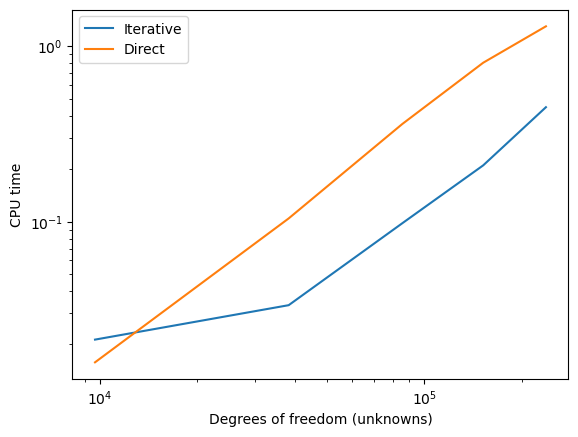

In [115]:
plt.loglog(dofs, tfis, label="Iterative")
plt.loglog(dofs, tfds, label="Direct")
plt.xlabel("Degrees of freedom (unknowns)")
plt.ylabel("CPU time")
plt.legend()
plt.show()

# Motivation problem: CFD

$$ \begin{aligned}-\Delta u + \nabla p = f\\ \mathrm{div}\, u = 0\end{aligned} \Leftrightarrow \begin{aligned}\int \nabla u\cdot \nabla v\,dx + \int p\, \mathrm{div}\, v\,dx && \forall v\in V \\ \int q \,\mathrm{div}\, u \,dx = 0 &&\forall q \in Q \end{aligned} \Leftrightarrow \begin{bmatrix} \mathbf{A} & \mathbf{B}^T \\ \mathbf{B} & \mathbf{0} \end{bmatrix}\begin{bmatrix} \mathbf{U} \\ \mathbf{P} \end{bmatrix} = \begin{bmatrix} \mathbf{F} \\ \mathbf{0} \end{bmatrix}$$

In [116]:
V = VectorH1(mesh, order=2, dirichlet="wall|inlet|cyl")
Q = H1(mesh, order=1)
X = V*Q
(u,p),(v,q) = X.TnT()

stokes = InnerProduct(Grad(u), Grad(v))*dx + div(u)*q*dx + div(v)*p*dx
a = BilinearForm(stokes)
f = LinearForm(v[0]*dx)
gf = GridFunction(X)
gfu, gfp = gf.components

uin = CF( (1.5*4*y*(0.41-y)/(0.41*0.41), 0) )
gfu.Set(uin, definedon=mesh.Boundaries("inlet"))
Draw(gfu, mesh, min=0, max=2)
SetVisualization(max=2)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

In [117]:
# Assembly operations do pending communication
a.Assemble()
f.Assemble()
res = f.vec -a.mat * gf.vec
inv = a.mat.Inverse(freedofs=X.FreeDofs(), inverse="umfpack")
gf.vec.data += inv * res
Draw(gfu)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [118]:
# Now we compute the nonzeros in the LU factorization
rows,cols,vals = a.mat.COO()
nnzA = len(vals)
A = sp.csr_matrix((vals,(rows,cols))) # NGSolve mat to scipy.sparse
LU = splu(A)
nnzs = LU.L.nnz + LU.U.nnz
print("Number of non-zeros of A:", nnzA)
print("Number of non-zeros of L+U:", nnzs)
print("Ratio of non-zeros:", len(vals)/nnzs)

Number of non-zeros of A: 24024
Number of non-zeros of L+U: 74931
Ratio of non-zeros: 0.320614965768507


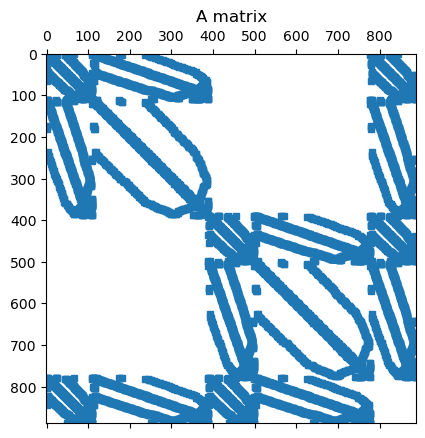

In [119]:
# Spy arrays
plt.spy(A, markersize=5.0)
plt.title("A matrix")
plt.show()

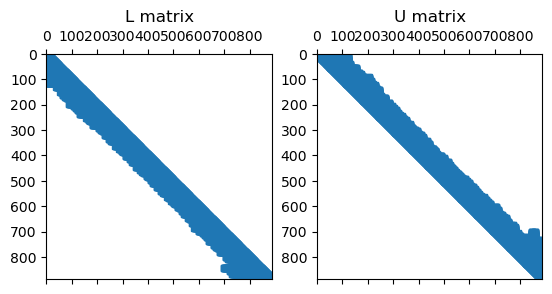

In [120]:
plt.subplot(1,2,1)
plt.spy(LU.L, markersize=5)
plt.title("L matrix")
plt.subplot(1,2,2)
plt.spy(LU.U, markersize=5)
plt.title("U matrix")
plt.show()

In [121]:
def convertToMb(nval):
    # 8 bytes per val 
    return nval * 8 * 1e-6
    
def computeNonzeros(maxh):
    mesh = Mesh(geo.GenerateMesh(maxh=maxh))
    mesh.Curve(3)
    V = VectorH1(mesh, order=2, dirichlet="wall|inlet|cyl")
    Q = H1(mesh, order=1)
    X = V*Q
    (u,p),(v,q) = X.TnT()
    
    stokes = InnerProduct(Grad(u), Grad(v))*dx + div(u)*q*dx + div(v)*p*dx
    a = BilinearForm(stokes)
    a.Assemble()
    rows,cols,vals = a.mat.COO()
    nnzA = len(vals)
    
    import scipy.sparse as sp
    A = sp.csr_matrix((vals,(rows,cols)))
    from scipy.sparse.linalg import splu # Sparse LU
    
    LU= splu(A)
    nnzs = LU.L.nnz + LU.U.nnz
    print("Number of non-zeros of A:", nnzA, "(in {:1.3f} Mb)".format(convertToMb(nnzA)))
    print("Number of non-zeros of L+U:", nnzs, "(in {:1.3f} Mb)".format(convertToMb(nnzs)))
    print("Ratio A.nnz / LU.nnz:", nnzA/nnzs)
    return nnzA, nnzs

In [122]:
for h in [0.1, 0.05, 0.01, 0.005]:
    print(f"========= Using h={h:1.3f}")
    nnza, nnzlu = computeNonzeros(h)

========= Using h=0.100
Number of non-zeros of A: 24024 (in 0.192 Mb)
Number of non-zeros of L+U: 74931 (in 0.599 Mb)
Ratio A.nnz / LU.nnz: 0.320614965768507
========= Using h=0.050
Number of non-zeros of A: 103041 (in 0.824 Mb)
Number of non-zeros of L+U: 642311 (in 5.138 Mb)
Ratio A.nnz / LU.nnz: 0.16042228764570435
========= Using h=0.010
Number of non-zeros of A: 2532409 (in 20.259 Mb)
Number of non-zeros of L+U: 57382418 (in 459.059 Mb)
Ratio A.nnz / LU.nnz: 0.04413214166053442
========= Using h=0.005
Number of non-zeros of A: 10091084 (in 80.729 Mb)
Number of non-zeros of L+U: 315893683 (in 2527.149 Mb)
Ratio A.nnz / LU.nnz: 0.0319445577517294


In [142]:
from time import perf_counter
def solveDirect(maxh, p):
    mesh = Mesh(geo.GenerateMesh(maxh=maxh))
    V = VectorH1(mesh, order=p+1, dirichlet="wall|inlet|cyl")
    Q = H1(mesh, order=p)
    X = V*Q
    (u,p),(v,q) = X.TnT()
    
    stokes = InnerProduct(Grad(u), Grad(v))*dx + div(u)*q*dx + div(v)*p*dx #-0.1*h*h*grad(p)*grad(q)*dx
    a = BilinearForm(stokes)
    f = LinearForm(v[0]*dx)
    gf = GridFunction(X)
    gfu, gfp = gf.components
    
    uin = CF( (1.5*4*y*(0.41-y)/(0.41*0.41), 0) )
    
    gfu.Set(uin, definedon=mesh.Boundaries("inlet"))
    a.Assemble()
    f.Assemble()
    t0 = perf_counter()
    inv = a.mat.Inverse()
    gf.vec.data += inv * f.vec
    tf = perf_counter() - t0
    return X.ndofglobal, tf

def solveIterative(maxh, p):
    mesh = Mesh(geo.GenerateMesh(maxh=maxh))
    V = VectorH1(mesh, order=p+1, dirichlet="wall|inlet|cyl")
    Q = H1(mesh, order=p)
    
    u,v = V.TnT()
    p,q = Q.TnT()

    
    a = BilinearForm(InnerProduct(Grad(u),Grad(v))*dx, symmetric=True)
    b = BilinearForm(div(u)*q*dx).Assemble()
    h = specialcf.mesh_size
    c = BilinearForm(-0.1*h*h*grad(p)*grad(q)*dx, symmetric=True).Assemble()
    
    mp = BilinearForm(p*q*dx, symmetric=True)
    f = LinearForm(V).Assemble()
    g = LinearForm(Q).Assemble();
    gfu = GridFunction(V, name="u")
    gfp = GridFunction(Q, name="p")
    uin = CoefficientFunction( (1.5*4*y*(0.41-y)/(0.41*0.41), 0) )
    gfu.Set(uin, definedon=mesh.Boundaries("inlet"))
    
    Qjacobi = Preconditioner(mp, "local")
    Amg = Preconditioner(a, "bddc")
    a.Assemble()
    mp.Assemble()
    K = BlockMatrix( [ [a.mat, b.mat.T], [b.mat, None] ] )
    C = BlockMatrix( [ [Amg.mat, None], [None, Qjacobi.mat] ] )
    
    rhs = BlockVector ( [f.vec, g.vec] )
    sol = BlockVector( [gfu.vec, gfp.vec] )
    t0 = perf_counter()
    solvers.MinRes (mat=K, pre=C, rhs=rhs, sol=sol, printrates='\r', initialize=False, maxsteps=200);
    tf = perf_counter() - t0
    
    return V.ndofglobal+Q.ndofglobal, tf


In [143]:
maxh = 0.01
tfds = []
tfis = []
dofs = []
maxhs = [0.2/2**i for i in range(7)]
for maxh in maxhs:
    print(f"========= Solving for h={maxh:1.3f}")
    dof, tfd = solveDirect(maxh,1)
    _, tfi = solveIterative(maxh,1)
    tfis.append(tfi)
    tfds.append(tfd)
    dofs.append(dof)
    print(f"Dofs:{dof:6.0f}, Direct: {tfd:1.3e}s, Iterative: {tfi:1.3e}s")

========= Solving for h=0.200
LinearSolver converged in 52 iterations to residual 1.2071213332099474e-07
Dofs:   234, Direct: 8.579e-04s, Iterative: 2.156e-03s
========= Solving for h=0.100
LinearSolver converged in 85 iterations to residual 2.3116848212041772e-07
Dofs:   888, Direct: 1.897e-03s, Iterative: 5.082e-03s
========= Solving for h=0.050
LinearSolver converged in 95 iterations to residual 4.726808118800878e-07
Dofs:  3627, Direct: 1.018e-02s, Iterative: 1.465e-02s
========= Solving for h=0.025
LinearSolver converged in 99 iterations to residual 7.699791543209e-07
Dofs: 14154, Direct: 6.538e-02s, Iterative: 5.673e-02s
========= Solving for h=0.013
LinearSolver converged in 103 iterations to residual 9.392560358838461e-07
Dofs: 55778, Direct: 4.358e-01s, Iterative: 2.948e-01s
========= Solving for h=0.006
LinearSolver converged in 103 iterations to residual 1.5415556765381026e-06
Dofs:219391, Direct: 2.732e+00s, Iterative: 1.790e+00s
========= Solving for h=0.003
LinearSolver c

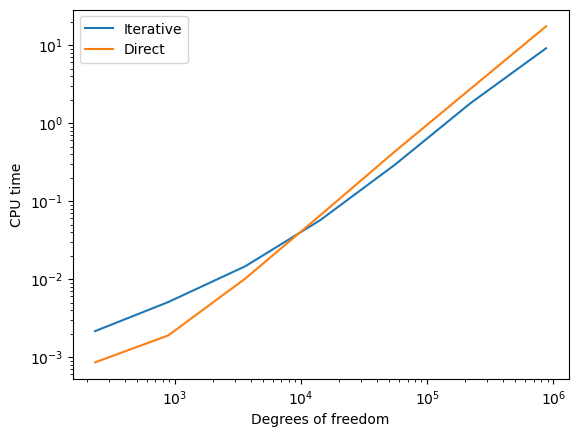

In [144]:
plt.loglog(dofs, tfis, label="Iterative")
plt.loglog(dofs, tfds, label="Direct")
plt.xlabel("Degrees of freedom")
plt.ylabel("CPU time")
plt.legend()
plt.show()

In [145]:
maxh = 0.01
tfds = []
tfis = []
dofs = []
ps = range(1,6)
for p in ps:
    print(f"========= Solving for h={maxh:1.3f}")
    dof, tfd = solveDirect(0.02, p)
    _, tfi = solveIterative(0.02, p)
    tfis.append(tfi)
    tfds.append(tfd)
    dofs.append(dof)
    print(f"Dofs:{dof:6.0f}, Direct: {tfd:1.3e}s, Iterative: {tfi:1.3e}s")

========= Solving for h=0.010
LinearSolver converged in 101 iterations to residual 7.903540617150554e-07
Dofs: 21506, Direct: 1.116e-01s, Iterative: 9.264e-02s
========= Solving for h=0.010
LinearSolver NOT converged in 200 iterations to residual 0.0007361939450303228
Dofs: 52055, Direct: 5.495e-01s, Iterative: 5.531e-01s
========= Solving for h=0.010
LinearSolver NOT converged in 200 iterations to residual 0.005133320059711326
Dofs: 96536, Direct: 1.468e+00s, Iterative: 1.337e+00s
========= Solving for h=0.010
LinearSolver NOT converged in 200 iterations to residual 0.013826689714966279
Dofs:154949, Direct: 3.126e+00s, Iterative: 2.786e+00s
========= Solving for h=0.010
LinearSolver NOT converged in 200 iterations to residual 0.03647956764394196
Dofs:227294, Direct: 6.311e+00s, Iterative: 5.103e+00s


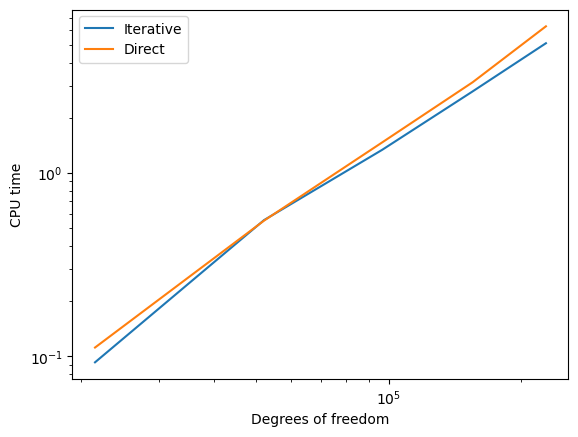

In [146]:
plt.loglog(dofs, tfis, label="Iterative")
plt.loglog(dofs, tfds, label="Direct")
plt.xlabel("Degrees of freedom")
plt.ylabel("CPU time")
plt.legend()
plt.show()

# Wrap up
- Direct methods have very limited scalability (_fill in_)
- Iterative methods overcome this but are more difficult
- We will understand this better by the end of tomorrow :)